In [1]:
import requests
import os
import logging
import gdown
import random

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torchvision.datasets import VOCSegmentation
import torchmetrics
import torchvision
import albumentations as A

import re
import string
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import cv2
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as T
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.io import loadmat
from sklearn.manifold import TSNE
from torchmetrics.classification import MulticlassF1Score, JaccardIndex, MulticlassPrecision, MulticlassRecall, MulticlassAveragePrecision
import pandas as pd
from torchinfo import torchinfo

from transformers import ConvNextV2Model, BertModel, BertTokenizer, ViTModel, ViTConfig
from transformers import AutoTokenizer, AutoModel, RobertaTokenizer, CLIPModel, CLIPTokenizer, CLIPProcessor
from transformers import DeiTConfig, DeiTFeatureExtractor, DeiTImageProcessor, DeiTModel
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import timm
from transformers import AlignModel, AlignProcessor, AlignConfig, AlignVisionConfig, AlignTextConfig
from transformers import CLIPModel, CLIPProcessor, CLIPConfig, CLIPTextConfig, CLIPVisionConfig, CLIPImageProcessor

from torchmetrics.functional import pairwise_cosine_similarity
from torchmetrics.classification import MultilabelAccuracy
from transformers import AutoImageProcessor, Swinv2Model

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
logging.basicConfig(level=logging.ERROR)

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:0")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")




There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3090


In [3]:
ROOT_DIR = '../Datasets/ocular-disease-recognition-odir5k/'

## RGB

In [4]:
BATCH_SIZE = 32

In [5]:
CSV_PATH = ROOT_DIR + 'dataset_single_eye.csv'
TEST_CSV = ROOT_DIR + 'TESTING_dataset_single_eye.csv'
IMG_PATH = ROOT_DIR + 'preprocessed_images/'

In [6]:
torchvision.io.read_image(IMG_PATH + '0_left.jpg').shape

torch.Size([3, 512, 512])

In [7]:
train_val_df = pd.read_csv(CSV_PATH)
test_df = pd.read_csv(TEST_CSV)

In [8]:
def preprocess_text(df:pd.DataFrame):
    df['Keywords'] = df['Keywords'].str.lower()
    df['Keywords'] = df['Keywords'].apply(lambda x: " ".join(x.split()))
    df['Keywords'] = df['Keywords'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
    return df
train_val_df = preprocess_text(train_val_df)
test_df = preprocess_text(test_df)

In [9]:
train_val_df['Patient Sex'] = train_val_df['Patient Sex'].astype('category').cat.codes
test_df['Patient Sex'] = test_df['Patient Sex'].astype('category').cat.codes

train_val_df['eye'] = train_val_df['Patient Sex'].astype('category').cat.codes
test_df['eye'] = test_df['Patient Sex'].astype('category').cat.codes

In [10]:
train_val_df

,ID,Patient Age,Patient Sex,Image,Keywords,eye,N,D,G,C,A,H,M,O,NOT DECISIVE
0,970,56,0,970_right.jpg,cataract,0,0,0,0,1,0,0,0,0,0
1,127,52,1,127_left.jpg,proliferative diabetic retinopathy，hypertensiv...,1,0,1,0,0,0,0,0,0,0
2,850,68,1,850_right.jpg,macular epiretinal membrane，moderate non proli...,1,0,1,0,0,0,0,0,0,0
3,37,41,1,37_right.jpg,normal fundus,1,1,0,0,0,0,0,0,0,0
4,4421,59,1,4421_right.jpg,moderate non proliferative retinopathy,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5733,199,50,0,199_left.jpg,branch retinal vein occlusion,0,0,0,0,0,0,0,0,1,0
5734,516,42,1,516_right.jpg,moderate non proliferative retinopathy,1,0,1,0,0,0,0,0,0,0
5735,4603,47,0,4603_left.jpg,severe nonproliferative retinopathy,0,0,1,0,0,0,0,0,0,0
5736,2132,59,0,2132_right.jpg,normal fundus,0,1,0,0,0,0,0,0,0,0


In [11]:
np.max(train_val_df['Keywords'].apply(lambda x: len(x.split())))

10

In [12]:
train_df, val_df = train_test_split(train_val_df, test_size = 0.15, random_state= 123456)
len(train_df), len(val_df)

(4877, 861)

In [13]:
IMG_SIZE = (224, 224)

rescale_transform = torchvision.transforms.Compose([
    #torchvision.transforms.CenterCrop(IMG_SIZE),
    torchvision.transforms.Resize(IMG_SIZE, antialias = False, interpolation = torchvision.transforms.InterpolationMode.NEAREST),
    torchvision.transforms.Normalize(
        timm.data.constants.IMAGENET_DEFAULT_MEAN,
        timm.data.constants.IMAGENET_DEFAULT_STD
    )
])

augmentation = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Resize(IMG_SIZE, antialias = False, interpolation = torchvision.transforms.InterpolationMode.NEAREST),
#     torchvision.transforms.RandomHorizontalFlip(p = 0.5),
#     torchvision.transforms.RandomVerticalFlip(p= 0.5),
    #torchvision.transforms.RandomRotation(90)
])

In [14]:
np.c_[train_val_df['Patient Age'].to_numpy(), train_val_df['Patient Sex'].to_numpy()]

array([[56,  0],
       [52,  1],
       [68,  1],
       ...,
       [47,  0],
       [59,  0],
       [55,  0]], dtype=int64)

In [15]:
class ODIRDataset(Dataset) :
    def __init__(self, df, IMG_FOLDER, extractor = rescale_transform, augmentation = None) :
        '''
        id : list of samples ids as string
        '''
        #self.text = [tokenizer(text = x, padding = 'max_length', max_length = 40, truncation = True, return_tensors = 'pt') for x in df['Keywords']]
        self.images = [Image.open(IMG_PATH + x).convert("RGB") for x in df['Image']]
        processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
        self.images = [processor(x, return_tensors="pt") for x in self.images]
        sex = df['Patient Age'].to_numpy()
        age = (df['Patient Age']/df['Patient Age'].max()).to_numpy()
        self.feats = torch.tensor(np.c_[sex, age], requires_grad= True)
        self.labels = torch.tensor(df[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].to_numpy()).float()
        self.img_dir = [IMG_PATH + x for x in df['Image']]

        self.augmentation = augmentation

#         self.images = [extractor(torchvision.io.read_image(x)/255.0) for x in self.img_dir]
        #self.transform = transform
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        batch_imgs = self.images[idx]
#         if(self.augmentation is not None):
#             batch_imgs = self.augmentation(batch_imgs)
        return batch_imgs, self.feats[idx], self.labels[idx]

In [16]:
# train_dataset = ODIRDataset(train_df, IMG_PATH, augmentation = augmentation)
# val_dataset   = ODIRDataset(val_df, IMG_PATH)
# test_dataset  = ODIRDataset(test_df, IMG_PATH)

In [17]:
# with open("datasets.trch", 'wb') as f:
#     torch.save([train_dataset, val_dataset, test_dataset], f)

In [18]:
with open("datasets.trch", 'rb') as f:
    train_dataset, val_dataset, test_dataset = torch.load(f)

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size= BATCH_SIZE)

In [20]:
class SwinTv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = Swinv2Model.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
        self.base.pooler = nn.AdaptiveAvgPool1d(output_size=1)
        self.fc = nn.Linear(768+2, 1000)
        self.img_head = nn.Linear(1000, 8)

    
    def forward(self, pixel_values, add_info):
        pixel_values = pixel_values['pixel_values']
        pixel_values = pixel_values.squeeze(1)
        out = self.base(pixel_values)['pooler_output']
        out = torch.hstack([out, add_info])
        out = F.relu(self.fc(out))
        out = self.img_head(out)

        out = F.sigmoid(out)
        return out#, img_outs, txt_outs

In [21]:
model= SwinTv2().to(device)

Some weights of the model checkpoint at microsoft/swinv2-tiny-patch4-window8-256 were not used when initializing Swinv2Model: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing Swinv2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Swinv2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
class EarlyStopping:

    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

early_stopping_rgb = EarlyStopping(patience=4, verbose=True, path = 'finetuned_swint_rgb.pt')

## RGB Model

In [23]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []


torch.cuda.empty_cache()
weights = torch.tensor([0.5, 1., 1.25, 1.25, 1.25, 1.3, 1.25, .9]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
train_img_acc = MultilabelAccuracy(8, average = 'micro').to(device)
val_img_acc = MultilabelAccuracy(8, average = 'micro').to(device)

img_loss_fn = nn.BCELoss(weights)

EPOCHS = 10

for epoch_num in range(EPOCHS):

  total_acc_train = 0
  total_loss_train = 0

  for train_image, train_metadata, train_label in tqdm(train_dataloader):
        optimizer.zero_grad()
        train_label = train_label.to(device)
        train_image = train_image.to(device)
        train_metadata = train_metadata.to(device).float()
      

        output = model(train_image, train_metadata)

        batch_loss = img_loss_fn(output, train_label)
        batch_loss.backward()
        optimizer.step()
        total_loss_train += batch_loss.item()
      
        train_img_acc(output, train_label)

  total_loss_val = 0

  with torch.no_grad():
      #Validation
      for val_image, val_metadata, val_label in val_dataloader:
        optimizer.zero_grad()
        val_label = val_label.to(device)
        val_image = val_image.to(device)
        val_metadata = val_metadata.to(device).float()
      

        output = model(val_image, val_metadata)

        batch_loss = img_loss_fn(output, val_label)
        total_loss_val += batch_loss.item()
        val_img_acc(output, val_label)
              
      
  avg_train_loss = total_loss_train/len(train_df)

  avg_val_loss = total_loss_val/len(val_df)


  print("Epoch [{}/{}], Train Loss: {:.4f}, acc img: {:.4f}".format(epoch_num+1, EPOCHS, avg_train_loss*BATCH_SIZE, train_img_acc.compute()))
  print("Epoch [{}/{}], Val Loss: {:.4f}, acc img: {:.4f}".format(epoch_num+1, EPOCHS, avg_val_loss*BATCH_SIZE, val_img_acc.compute()))
  early_stopping_rgb(avg_val_loss, model)

  if early_stopping_rgb.early_stop:
      print("Early stopping")
      print('-'*60)
      break

  train_acc.append(train_img_acc.compute())
  val_acc.append(val_img_acc.compute())
  train_loss.append(avg_train_loss)
  val_loss.append(avg_val_loss)
  train_img_acc.reset()
  val_img_acc.reset()

  torch.save(model.state_dict(), './' + 'checkpoint_swint_rgb' + '.pt' )

#torch.save(model.state_dict(), './' + 'finetuned_swint_rgb' + '.pt' )


100%|██████████| 153/153 [00:45<00:00,  3.37it/s]


Epoch [1/10], Train Loss: 0.2686, acc img: 0.8838
Epoch [1/10], Val Loss: 0.2149, acc img: 0.9027
Validation loss decreased (inf --> 0.006717).  Saving model ...


100%|██████████| 153/153 [00:44<00:00,  3.47it/s]


Epoch [2/10], Train Loss: 0.1919, acc img: 0.9098
Epoch [2/10], Val Loss: 0.1926, acc img: 0.9096
Validation loss decreased (0.006717 --> 0.006018).  Saving model ...


100%|██████████| 153/153 [00:44<00:00,  3.46it/s]


Epoch [3/10], Train Loss: 0.1679, acc img: 0.9224
Epoch [3/10], Val Loss: 0.1806, acc img: 0.9191
Validation loss decreased (0.006018 --> 0.005644).  Saving model ...


100%|██████████| 153/153 [00:46<00:00,  3.27it/s]


Epoch [4/10], Train Loss: 0.1492, acc img: 0.9302
Epoch [4/10], Val Loss: 0.1777, acc img: 0.9183
Validation loss decreased (0.005644 --> 0.005554).  Saving model ...


100%|██████████| 153/153 [00:43<00:00,  3.48it/s]


Epoch [5/10], Train Loss: 0.1283, acc img: 0.9431
Epoch [5/10], Val Loss: 0.1811, acc img: 0.9181
EarlyStopping counter: 1 out of 4


100%|██████████| 153/153 [00:46<00:00,  3.29it/s]


Epoch [6/10], Train Loss: 0.1062, acc img: 0.9541
Epoch [6/10], Val Loss: 0.1805, acc img: 0.9183
EarlyStopping counter: 2 out of 4


100%|██████████| 153/153 [00:43<00:00,  3.55it/s]


Epoch [7/10], Train Loss: 0.0801, acc img: 0.9673
Epoch [7/10], Val Loss: 0.1952, acc img: 0.9194
EarlyStopping counter: 3 out of 4


100%|██████████| 153/153 [00:43<00:00,  3.55it/s]


Epoch [8/10], Train Loss: 0.0550, acc img: 0.9792
Epoch [8/10], Val Loss: 0.2207, acc img: 0.9175
EarlyStopping counter: 4 out of 4
Early stopping
------------------------------------------------------------


In [27]:
ac_t = [x.item() for x in train_acc] 
ac_t = [x.item() for x in val_acc] 

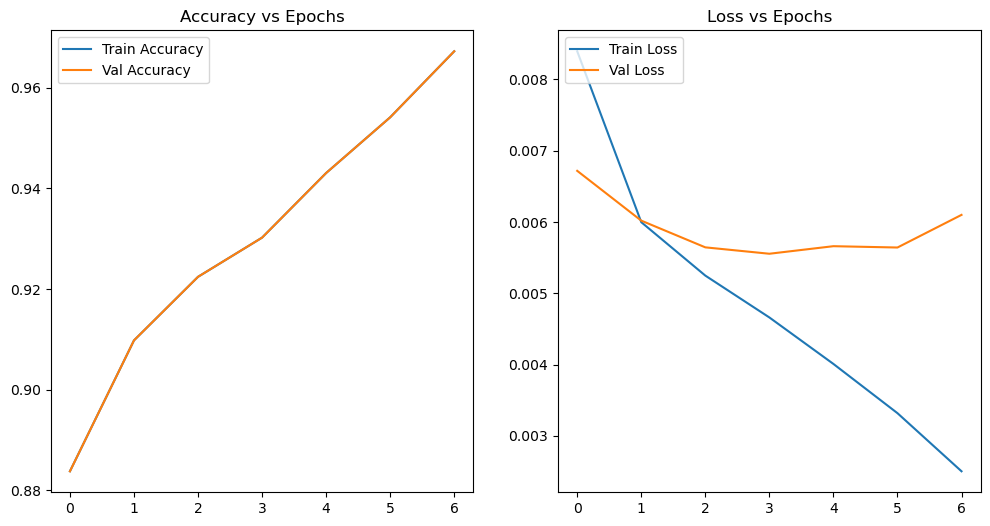

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].plot(range(len(train_acc)), ac_t, label = 'Train Accuracy')
ax[0].plot(range(len(train_acc)), ac_t, label = 'Val Accuracy')
ax[0].set_title("Accuracy vs Epochs")
ax[0].legend(loc = 'upper left')

ax[1].plot(range(len(train_acc)), train_loss, label = 'Train Loss')
ax[1].plot(range(len(train_acc)), val_loss, label = 'Val Loss')
ax[1].set_title("Loss vs Epochs")
ax[1].legend(loc = 'upper left')

In [96]:
with open("finetuned_swint_rgb.pt", 'rb') as f:
    model.load_state_dict(torch.load(f))

#### Evaluation on test set

In [97]:
#criterion = nn.BCELoss(torch.tensor([0.5, 1, 5, 5, 5, 6, 5, 1]).float().to(device))

test_loss = 0
test_acc  = 0

AVERAGING = 'micro'
PREC = torchmetrics.classification.MultilabelPrecision(8, average = AVERAGING).to(device)#, validate_args = False)
ACC = torchmetrics.classification.MultilabelAccuracy(8, average = AVERAGING).to(device)#, validate_args = False)
REC = torchmetrics.classification.MultilabelRecall(8, average = AVERAGING).to(device)#, validate_args = False)
F1_SCORE = torchmetrics.classification.MultilabelF1Score(8, average = AVERAGING).to(device)#, validate_args = False)
F_BETA_SCORE = torchmetrics.classification.MultilabelFBetaScore(beta = 0.8, num_classes = 8, num_labels = 8, average = AVERAGING).to(device)#, validate_args = False)
KAPPA = torchmetrics.classification.MulticlassCohenKappa(8).to(device)#, validate_args = False)
AUC = torchmetrics.classification.MultilabelAUROC(8, average = AVERAGING).to(device)#, validate_args = False)

for train_image, train_metadata, train_label in tqdm(test_dataloader): 
    with torch.no_grad():
        optimizer.zero_grad()
        train_label = train_label.to(device)
        train_image = train_image.to(device)
        train_metadata = train_metadata.to(device).float()
      

        predictions = model(train_image, train_metadata)


        train_label = train_label.long()
        PREC(predictions, train_label)
        ACC(predictions, train_label)
        REC(predictions, train_label)
        F1_SCORE(predictions, train_label)
        F_BETA_SCORE(predictions, train_label)
        KAPPA(predictions, train_label)
        AUC(predictions, train_label)


add_prec = PREC.compute()
add_acc = ACC.compute()
add_rec = REC.compute()
add_f1 = F1_SCORE.compute()
add_fbeta = F_BETA_SCORE.compute()
add_kappa = KAPPA.compute()
add_auc = AUC.compute()

avg_test_loss = test_loss/len(test_df)*BATCH_SIZE
avg_test_acc  = test_acc /len(test_df)

print("Acc: {:3f}\nPrec: {:3f}\nRecall: {:.3f}\nF1-score: {:.3f}\nF-Beta-score: {:.3f}\nKappa: {:.3f}\nAUC: {:.3f}".format(add_acc, add_prec,add_rec, add_f1, add_fbeta, add_kappa, add_auc))
torch.cuda.empty_cache()

100%|██████████| 20/20 [00:02<00:00,  7.38it/s]

Acc: 0.913793
Prec: 0.701219
Recall: 0.541
F1-score: 0.611
F-Beta-score: 0.628
Kappa: 0.000
AUC: 0.938


In [98]:
torch.cuda.empty_cache()

## Histeq

In [99]:
BATCH_SIZE = 32

In [100]:
CSV_PATH = ROOT_DIR + 'dataset_single_eye.csv'
TEST_CSV = ROOT_DIR + 'TESTING_dataset_single_eye.csv'
IMG_PATH = ROOT_DIR + 'preprocessed_histeq_images/'

In [101]:
torchvision.io.read_image(IMG_PATH + '0_left.jpg').shape

torch.Size([1, 512, 512])

In [102]:
train_val_df = pd.read_csv(CSV_PATH)
test_df = pd.read_csv(TEST_CSV)

In [103]:
def preprocess_text(df:pd.DataFrame):
    df['Keywords'] = df['Keywords'].str.lower()
    df['Keywords'] = df['Keywords'].apply(lambda x: " ".join(x.split()))
    df['Keywords'] = df['Keywords'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
    return df
train_val_df = preprocess_text(train_val_df)
test_df = preprocess_text(test_df)

In [104]:
train_val_df['Patient Sex'] = train_val_df['Patient Sex'].astype('category').cat.codes
test_df['Patient Sex'] = test_df['Patient Sex'].astype('category').cat.codes

train_val_df['eye'] = train_val_df['Patient Sex'].astype('category').cat.codes
test_df['eye'] = test_df['Patient Sex'].astype('category').cat.codes

In [105]:
train_val_df

,ID,Patient Age,Patient Sex,Image,Keywords,eye,N,D,G,C,A,H,M,O,NOT DECISIVE
0,970,56,0,970_right.jpg,cataract,0,0,0,0,1,0,0,0,0,0
1,127,52,1,127_left.jpg,proliferative diabetic retinopathy，hypertensiv...,1,0,1,0,0,0,0,0,0,0
2,850,68,1,850_right.jpg,macular epiretinal membrane，moderate non proli...,1,0,1,0,0,0,0,0,0,0
3,37,41,1,37_right.jpg,normal fundus,1,1,0,0,0,0,0,0,0,0
4,4421,59,1,4421_right.jpg,moderate non proliferative retinopathy,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5733,199,50,0,199_left.jpg,branch retinal vein occlusion,0,0,0,0,0,0,0,0,1,0
5734,516,42,1,516_right.jpg,moderate non proliferative retinopathy,1,0,1,0,0,0,0,0,0,0
5735,4603,47,0,4603_left.jpg,severe nonproliferative retinopathy,0,0,1,0,0,0,0,0,0,0
5736,2132,59,0,2132_right.jpg,normal fundus,0,1,0,0,0,0,0,0,0,0


In [106]:
np.max(train_val_df['Keywords'].apply(lambda x: len(x.split())))

10

In [107]:
train_df, val_df = train_test_split(train_val_df, test_size = 0.15, random_state= 123456)
len(train_df), len(val_df)

(4877, 861)

In [108]:
IMG_SIZE = (224, 224)

rescale_transform = torchvision.transforms.Compose([
    #torchvision.transforms.CenterCrop(IMG_SIZE),
    torchvision.transforms.Resize(IMG_SIZE, antialias = False, interpolation = torchvision.transforms.InterpolationMode.NEAREST),
    torchvision.transforms.Normalize(
        timm.data.constants.IMAGENET_DEFAULT_MEAN,
        timm.data.constants.IMAGENET_DEFAULT_STD
    )
])

augmentation = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Resize(IMG_SIZE, antialias = False, interpolation = torchvision.transforms.InterpolationMode.NEAREST),
#     torchvision.transforms.RandomHorizontalFlip(p = 0.5),
#     torchvision.transforms.RandomVerticalFlip(p= 0.5),
    #torchvision.transforms.RandomRotation(90)
])

In [109]:
np.c_[train_val_df['Patient Age'].to_numpy(), train_val_df['Patient Sex'].to_numpy()]

array([[56,  0],
       [52,  1],
       [68,  1],
       ...,
       [47,  0],
       [59,  0],
       [55,  0]], dtype=int64)

In [110]:
class ODIRDataset(Dataset) :
    def __init__(self, df, IMG_FOLDER, extractor = rescale_transform, augmentation = None) :
        '''
        id : list of samples ids as string
        '''
        #self.text = [tokenizer(text = x, padding = 'max_length', max_length = 40, truncation = True, return_tensors = 'pt') for x in df['Keywords']]
        self.images = [Image.open(IMG_PATH + x).convert("RGB") for x in df['Image']]
        processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
        self.images = [processor(x, return_tensors="pt") for x in self.images]
        sex = df['Patient Age'].to_numpy()
        age = (df['Patient Age']/df['Patient Age'].max()).to_numpy()
        self.feats = torch.tensor(np.c_[sex, age], requires_grad= True)
        self.labels = torch.tensor(df[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].to_numpy()).float()
        self.img_dir = [IMG_PATH + x for x in df['Image']]

        self.augmentation = augmentation

#         self.images = [extractor(torchvision.io.read_image(x)/255.0) for x in self.img_dir]
        #self.transform = transform
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        batch_imgs = self.images[idx]
#         if(self.augmentation is not None):
#             batch_imgs = self.augmentation(batch_imgs)
        return batch_imgs, self.feats[idx], self.labels[idx]

In [111]:
# train_dataset = ODIRDataset(train_df, IMG_PATH, augmentation = augmentation)
# val_dataset   = ODIRDataset(val_df, IMG_PATH)
# test_dataset  = ODIRDataset(test_df, IMG_PATH)

In [112]:
# with open("datasets_hist.trch", 'wb') as f:
#     torch.save([train_dataset, val_dataset, test_dataset], f)

In [113]:
with open("datasets_hist.trch", 'rb') as f:
    train_dataset, val_dataset, test_dataset = torch.load(f)

In [114]:
train_dataloader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size= BATCH_SIZE)

In [115]:
class SwinTv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = Swinv2Model.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
        self.base.pooler = nn.AdaptiveAvgPool1d(output_size=1)
        self.fc = nn.Linear(768+2, 1000)
        self.img_head = nn.Linear(1000, 8)

    
    def forward(self, pixel_values, add_info):
        pixel_values = pixel_values['pixel_values']
        pixel_values = pixel_values.squeeze(1)
        out = self.base(pixel_values)['pooler_output']
        out = torch.hstack([out, add_info])
        out = F.relu(self.fc(out))
        out = self.img_head(out)

        out = F.sigmoid(out)
        return out#, img_outs, txt_outs

In [116]:
model= SwinTv2().to(device)

Some weights of the model checkpoint at microsoft/swinv2-tiny-patch4-window8-256 were not used when initializing Swinv2Model: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing Swinv2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Swinv2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [117]:
class EarlyStopping:

    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=4, verbose=True, path = 'finetuned_swint_hist.pt')

In [118]:
torch.cuda.empty_cache()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
train_img_acc = MultilabelAccuracy(8, average = 'micro').to(device)
val_img_acc = MultilabelAccuracy(8, average = 'micro').to(device)

img_loss_fn = nn.BCELoss(weights)

EPOCHS = 10

for epoch_num in range(EPOCHS):

  total_acc_train = 0
  total_loss_train = 0

  for train_image, train_metadata, train_label in tqdm(train_dataloader):
        optimizer.zero_grad()
        train_label = train_label.to(device)
        train_image = train_image.to(device)
        train_metadata = train_metadata.to(device).float()
      

        output = model(train_image, train_metadata)

        batch_loss = img_loss_fn(output, train_label)
        batch_loss.backward()
        optimizer.step()
        total_loss_train += batch_loss.item()
      
        train_img_acc(output, train_label)

  total_loss_val = 0

  with torch.no_grad():
      #Validation
      for val_image, val_metadata, val_label in val_dataloader:
        optimizer.zero_grad()
        val_label = val_label.to(device)
        val_image = val_image.to(device)
        val_metadata = val_metadata.to(device).float()
      

        output = model(val_image, val_metadata)

        batch_loss = img_loss_fn(output, val_label)
        total_loss_val += batch_loss.item()
        val_img_acc(output, val_label)
              
      
  avg_train_loss = total_loss_train/len(train_df)

  avg_val_loss = total_loss_val/len(val_df)


  print("Epoch [{}/{}], Train Loss: {:.4f}, acc img: {:.4f}".format(epoch_num+1, EPOCHS, avg_train_loss*BATCH_SIZE, train_img_acc.compute()))
  print("Epoch [{}/{}], Val Loss: {:.4f}, acc img: {:.4f}".format(epoch_num+1, EPOCHS, avg_val_loss*BATCH_SIZE, val_img_acc.compute()))
  early_stopping(avg_val_loss, model)

  if early_stopping.early_stop:
      print("Early stopping")
      print('-'*60)
      break
  train_img_acc.reset()
  val_img_acc.reset()

  #torch.save(model.state_dict(), './' + 'checkpoint_swint_hist' + '.pt' )

#torch.save(model.state_dict(), './' + 'finetuned_swint_hist' + '.pt' )


100%|██████████| 153/153 [00:50<00:00,  3.04it/s]


Epoch [1/10], Train Loss: 0.2916, acc img: 0.8645
Epoch [1/10], Val Loss: 0.2304, acc img: 0.8939
Validation loss decreased (inf --> 0.007200).  Saving model ...


100%|██████████| 153/153 [00:51<00:00,  3.00it/s]


Epoch [2/10], Train Loss: 0.2061, acc img: 0.9042
Epoch [2/10], Val Loss: 0.1996, acc img: 0.9106
Validation loss decreased (0.007200 --> 0.006237).  Saving model ...


100%|██████████| 153/153 [00:52<00:00,  2.91it/s]


Epoch [3/10], Train Loss: 0.1811, acc img: 0.9165
Epoch [3/10], Val Loss: 0.1891, acc img: 0.9152
Validation loss decreased (0.006237 --> 0.005908).  Saving model ...


100%|██████████| 153/153 [00:52<00:00,  2.90it/s]


Epoch [4/10], Train Loss: 0.1596, acc img: 0.9261
Epoch [4/10], Val Loss: 0.1889, acc img: 0.9116
Validation loss decreased (0.005908 --> 0.005902).  Saving model ...


100%|██████████| 153/153 [00:49<00:00,  3.10it/s]


Epoch [5/10], Train Loss: 0.1420, acc img: 0.9354
Epoch [5/10], Val Loss: 0.1831, acc img: 0.9164
Validation loss decreased (0.005902 --> 0.005722).  Saving model ...


100%|██████████| 153/153 [00:49<00:00,  3.10it/s]


Epoch [6/10], Train Loss: 0.1222, acc img: 0.9451
Epoch [6/10], Val Loss: 0.1854, acc img: 0.9181
EarlyStopping counter: 1 out of 4


100%|██████████| 153/153 [00:52<00:00,  2.93it/s]


Epoch [7/10], Train Loss: 0.0984, acc img: 0.9584
Epoch [7/10], Val Loss: 0.1972, acc img: 0.9165
EarlyStopping counter: 2 out of 4


100%|██████████| 153/153 [01:00<00:00,  2.54it/s]


Epoch [8/10], Train Loss: 0.0739, acc img: 0.9705
Epoch [8/10], Val Loss: 0.2107, acc img: 0.9191
EarlyStopping counter: 3 out of 4


100%|██████████| 153/153 [00:56<00:00,  2.70it/s]


Epoch [9/10], Train Loss: 0.0504, acc img: 0.9824
Epoch [9/10], Val Loss: 0.2413, acc img: 0.9148
EarlyStopping counter: 4 out of 4
Early stopping
------------------------------------------------------------


In [119]:
with open("finetuned_swint_hist.pt", 'rb') as f:
    model.load_state_dict(torch.load(f))

## Evaluation on test set

In [120]:
#criterion = nn.BCELoss(torch.tensor([0.5, 1, 5, 5, 5, 6, 5, 1]).float().to(device))

test_loss = 0
test_acc  = 0

AVERAGING = 'micro'
PREC = torchmetrics.classification.MultilabelPrecision(8, average = AVERAGING).to(device)#, validate_args = False)
ACC = torchmetrics.classification.MultilabelAccuracy(8, average = AVERAGING).to(device)#, validate_args = False)
REC = torchmetrics.classification.MultilabelRecall(8, average = AVERAGING).to(device)#, validate_args = False)
F1_SCORE = torchmetrics.classification.MultilabelF1Score(8, average = AVERAGING).to(device)#, validate_args = False)
F_BETA_SCORE = torchmetrics.classification.MultilabelFBetaScore(beta = 0.8, num_classes = 8, num_labels = 8, average = AVERAGING).to(device)#, validate_args = False)
KAPPA = torchmetrics.classification.MulticlassCohenKappa(8).to(device)#, validate_args = False)
AUC = torchmetrics.classification.MultilabelAUROC(8, average = AVERAGING).to(device)#, validate_args = False)

for train_image, train_metadata, train_label in tqdm(test_dataloader): 
    with torch.no_grad():
        optimizer.zero_grad()
        train_label = train_label.to(device)
        train_image = train_image.to(device)
        train_metadata = train_metadata.to(device).float()
      

        predictions = model(train_image, train_metadata)


        train_label = train_label.long()
        PREC(predictions, train_label)
        ACC(predictions, train_label)
        REC(predictions, train_label)
        F1_SCORE(predictions, train_label)
        F_BETA_SCORE(predictions, train_label)
        KAPPA(predictions, train_label)
        AUC(predictions, train_label)


add_prec = PREC.compute()
add_acc = ACC.compute()
add_rec = REC.compute()
add_f1 = F1_SCORE.compute()
add_fbeta = F_BETA_SCORE.compute()
add_kappa = KAPPA.compute()
add_auc = AUC.compute()

avg_test_loss = test_loss/len(test_df)*BATCH_SIZE
avg_test_acc  = test_acc /len(test_df)

print("Acc: {:3f}\nPrec: {:3f}\nRecall: {:.3f}\nF1-score: {:.3f}\nF-Beta-score: {:.3f}\nKappa: {:.3f}\nAUC: {:.3f}".format(add_acc, add_prec,add_rec, add_f1, add_fbeta, add_kappa, add_auc))
torch.cuda.empty_cache()

100%|██████████| 20/20 [00:05<00:00,  3.47it/s]

Acc: 0.913401
Prec: 0.697581
Recall: 0.542
F1-score: 0.610
F-Beta-score: 0.627
Kappa: 0.000
AUC: 0.932


In [121]:
torch.cuda.empty_cache()

# ENSEMBLE STRATEGY

In [122]:
BATCH_SIZE = 32

In [123]:
CSV_PATH = ROOT_DIR + 'dataset_single_eye.csv'
TEST_CSV = ROOT_DIR + 'TESTING_dataset_single_eye.csv'
IMG_PATH = ROOT_DIR + 'preprocessed_images/'
HIST_IMG_PATH = ROOT_DIR + 'preprocessed_histeq_images/'

In [124]:
torchvision.io.read_image(IMG_PATH + '0_left.jpg').shape

torch.Size([3, 512, 512])

In [125]:
train_val_df = pd.read_csv(CSV_PATH)
test_df = pd.read_csv(TEST_CSV)

In [126]:
def preprocess_text(df:pd.DataFrame):
    df['Keywords'] = df['Keywords'].str.lower()
    df['Keywords'] = df['Keywords'].apply(lambda x: " ".join(x.split()))
    df['Keywords'] = df['Keywords'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
    return df
train_val_df = preprocess_text(train_val_df)
test_df = preprocess_text(test_df)

In [127]:
train_val_df['Patient Sex'] = train_val_df['Patient Sex'].astype('category').cat.codes
test_df['Patient Sex'] = test_df['Patient Sex'].astype('category').cat.codes

train_val_df['eye'] = train_val_df['Patient Sex'].astype('category').cat.codes
test_df['eye'] = test_df['Patient Sex'].astype('category').cat.codes

In [128]:
train_val_df

,ID,Patient Age,Patient Sex,Image,Keywords,eye,N,D,G,C,A,H,M,O,NOT DECISIVE
0,970,56,0,970_right.jpg,cataract,0,0,0,0,1,0,0,0,0,0
1,127,52,1,127_left.jpg,proliferative diabetic retinopathy，hypertensiv...,1,0,1,0,0,0,0,0,0,0
2,850,68,1,850_right.jpg,macular epiretinal membrane，moderate non proli...,1,0,1,0,0,0,0,0,0,0
3,37,41,1,37_right.jpg,normal fundus,1,1,0,0,0,0,0,0,0,0
4,4421,59,1,4421_right.jpg,moderate non proliferative retinopathy,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5733,199,50,0,199_left.jpg,branch retinal vein occlusion,0,0,0,0,0,0,0,0,1,0
5734,516,42,1,516_right.jpg,moderate non proliferative retinopathy,1,0,1,0,0,0,0,0,0,0
5735,4603,47,0,4603_left.jpg,severe nonproliferative retinopathy,0,0,1,0,0,0,0,0,0,0
5736,2132,59,0,2132_right.jpg,normal fundus,0,1,0,0,0,0,0,0,0,0


In [129]:
np.max(train_val_df['Keywords'].apply(lambda x: len(x.split())))

10

In [130]:
train_df, val_df = train_test_split(train_val_df, test_size = 0.15, random_state= 123456)
len(train_df), len(val_df)

(4877, 861)

In [131]:
IMG_SIZE = (224, 224)

rescale_transform = torchvision.transforms.Compose([
    #torchvision.transforms.CenterCrop(IMG_SIZE),
    torchvision.transforms.Resize(IMG_SIZE, antialias = False, interpolation = torchvision.transforms.InterpolationMode.NEAREST),
    torchvision.transforms.Normalize(
        timm.data.constants.IMAGENET_DEFAULT_MEAN,
        timm.data.constants.IMAGENET_DEFAULT_STD
    )
])

augmentation = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Resize(IMG_SIZE, antialias = False, interpolation = torchvision.transforms.InterpolationMode.NEAREST),
#     torchvision.transforms.RandomHorizontalFlip(p = 0.5),
#     torchvision.transforms.RandomVerticalFlip(p= 0.5),
    #torchvision.transforms.RandomRotation(90)
])

In [132]:
np.c_[train_val_df['Patient Age'].to_numpy(), train_val_df['Patient Sex'].to_numpy()]

array([[56,  0],
       [52,  1],
       [68,  1],
       ...,
       [47,  0],
       [59,  0],
       [55,  0]], dtype=int64)

In [133]:
class ODIRDataset(Dataset) :
    def __init__(self, df, IMG_FOLDER, extractor = rescale_transform, augmentation = None) :
        '''
        id : list of samples ids as string
        '''
        #self.text = [tokenizer(text = x, padding = 'max_length', max_length = 40, truncation = True, return_tensors = 'pt') for x in df['Keywords']]
        self.images = [Image.open(IMG_PATH + x).convert("RGB") for x in df['Image']]
        self.hist_images = [Image.open(HIST_IMG_PATH + x).convert("RGB") for x in df['Image']]
        processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
        self.images = [processor(x, return_tensors="pt") for x in self.images]
        self.hist_images = [processor(x, return_tensors="pt") for x in self.hist_images]
        sex = df['Patient Age'].to_numpy()
        age = (df['Patient Age']/df['Patient Age'].max()).to_numpy()
        self.feats = torch.tensor(np.c_[sex, age], requires_grad= True)
        self.labels = torch.tensor(df[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].to_numpy()).float()
        self.img_dir = [IMG_PATH + x for x in df['Image']]

        self.augmentation = augmentation

#         self.images = [extractor(torchvision.io.read_image(x)/255.0) for x in self.img_dir]
        #self.transform = transform
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        batch_imgs = self.images[idx]
        batch_hist_imgs = self.hist_images[idx]
#         if(self.augmentation is not None):
#             batch_imgs = self.augmentation(batch_imgs)
        return batch_imgs, batch_hist_imgs, self.feats[idx], self.labels[idx]

In [134]:
# train_dataset = ODIRDataset(train_df, IMG_PATH, augmentation = augmentation)
# val_dataset   = ODIRDataset(val_df, IMG_PATH)
# test_dataset  = ODIRDataset(test_df, IMG_PATH)

In [135]:
# with open("datasets_en.trch", 'wb') as f:
#     torch.save([train_dataset, val_dataset, test_dataset], f)

In [136]:
with open("datasets_en.trch", 'rb') as f:
    train_dataset, val_dataset, test_dataset = torch.load(f)

In [137]:
train_dataloader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size= BATCH_SIZE)

In [7]:
class SwinTv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = Swinv2Model.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
        self.base.pooler = nn.AdaptiveAvgPool1d(output_size=1)
        self.fc = nn.Linear(768+2, 1000)
        self.img_head = nn.Linear(1000, 8)

    
    def forward(self, pixel_values, add_info):
        pixel_values = pixel_values['pixel_values']
        pixel_values = pixel_values.squeeze(1)
        out = self.base(pixel_values)['pooler_output']
        out = torch.hstack([out, add_info])
        out = F.relu(self.fc(out))
        out = self.img_head(out)

        out = F.sigmoid(out)
        return out#, img_outs, txt_outs

In [5]:
def load_model(path, device="cpu"):
    model = SwinTv2().to(device)
    model.load_state_dict(torch.load(path))
    model = model.to(device)
    return model

In [3]:
class en_SwinTv2():    
    def __init__(self, normal_path, grey_path) :
        self.normal_SwinTv2 = load_model(normal_path,device="cuda")
        self.grey_SwinTv2 = load_model(grey_path,device="cuda")
        
    def test_sample(self, sample, sample_hist, train_metadata):
        output_normal = self.normal_SwinTv2(sample, train_metadata)
        output_grey = self.grey_SwinTv2(sample_hist, train_metadata)
        outputs = torch.add(output_normal, output_grey)
        outputs = torch.div(outputs, 2)
        return outputs

    def test(self, test_loader):
        self.normal_SwinTv2.eval()
        self.grey_SwinTv2.eval()
        with torch.no_grad():
            torch.cuda.empty_cache()
            test_loss = 0
            test_acc  = 0

            AVERAGING = 'micro'
            PREC = torchmetrics.classification.MultilabelPrecision(8, average = AVERAGING).to(device)#, validate_args = False)
            ACC = torchmetrics.classification.MultilabelAccuracy(8, average = AVERAGING).to(device)#, validate_args = False)
            REC = torchmetrics.classification.MultilabelRecall(8, average = AVERAGING).to(device)#, validate_args = False)
            F1_SCORE = torchmetrics.classification.MultilabelF1Score(8, average = AVERAGING).to(device)#, validate_args = False)
            F_BETA_SCORE = torchmetrics.classification.MultilabelFBetaScore(beta = 0.8, num_classes = 8, num_labels = 8, average = AVERAGING).to(device)#, validate_args = False)
            KAPPA = torchmetrics.classification.MulticlassCohenKappa(8).to(device)#, validate_args = False)
            AUC = torchmetrics.classification.MultilabelAUROC(8, average = AVERAGING).to(device)#, validate_args = False)

            for train_image, train_hist_image, train_metadata, train_label in tqdm(test_dataloader): 
                with torch.no_grad():
                    optimizer.zero_grad()
                    train_label = train_label.to(device)
                    train_image = train_image.to(device)
                    train_hist_image = train_hist_image.to(device)
                    train_metadata = train_metadata.to(device).float()


                    predictions = self.test_sample(train_image, train_hist_image, train_metadata)


                    train_label = train_label.long()
                    PREC(predictions, train_label)
                    ACC(predictions, train_label)
                    REC(predictions, train_label)
                    F1_SCORE(predictions, train_label)
                    F_BETA_SCORE(predictions, train_label)
                    KAPPA(predictions, train_label)
                    AUC(predictions, train_label)


            add_prec = PREC.compute()
            add_acc = ACC.compute()
            add_rec = REC.compute()
            add_f1 = F1_SCORE.compute()
            add_fbeta = F_BETA_SCORE.compute()
            add_kappa = KAPPA.compute()
            add_auc = AUC.compute()

            avg_test_loss = test_loss/len(test_df)*BATCH_SIZE
            avg_test_acc  = test_acc /len(test_df)

            print("Acc: {:3f}\nPrec: {:3f}\nRecall: {:.3f}\nF1-score: {:.3f}\nF-Beta-score: {:.3f}\nKappa: {:.3f}\nAUC: {:.3f}".format(add_acc, add_prec,add_rec, add_f1, add_fbeta, add_kappa, add_auc))
            torch.cuda.empty_cache()

## Evaluation on test set

In [141]:
# #criterion = nn.BCELoss(torch.tensor([0.5, 1, 5, 5, 5, 6, 5, 1]).float().to(device))

# test_loss = 0
# test_acc  = 0

# AVERAGING = 'micro'
# PREC = torchmetrics.classification.MultilabelPrecision(8, average = AVERAGING).to(device)#, validate_args = False)
# ACC = torchmetrics.classification.MultilabelAccuracy(8, average = AVERAGING).to(device)#, validate_args = False)
# REC = torchmetrics.classification.MultilabelRecall(8, average = AVERAGING).to(device)#, validate_args = False)
# F1_SCORE = torchmetrics.classification.MultilabelF1Score(8, average = AVERAGING).to(device)#, validate_args = False)
# F_BETA_SCORE = torchmetrics.classification.MultilabelFBetaScore(beta = 0.8, num_classes = 8, num_labels = 8, average = AVERAGING).to(device)#, validate_args = False)
# KAPPA = torchmetrics.classification.MulticlassCohenKappa(8).to(device)#, validate_args = False)
# AUC = torchmetrics.classification.MultilabelAUROC(8, average = AVERAGING).to(device)#, validate_args = False)

# for train_image, train_metadata, train_label in tqdm(test_dataloader): 
#     with torch.no_grad():
#         optimizer.zero_grad()
#         train_label = train_label.to(device)
#         train_image = train_image.to(device)
#         train_metadata = train_metadata.to(device)
      

#         predictions = model(train_image, train_metadata)


#         train_label = train_label.long()
#         PREC(predictions, train_label)
#         ACC(predictions, train_label)
#         REC(predictions, train_label)
#         F1_SCORE(predictions, train_label)
#         F_BETA_SCORE(predictions, train_label)
#         KAPPA(predictions, train_label)
#         AUC(predictions, train_label)


# add_prec = PREC.compute()
# add_acc = ACC.compute()
# add_rec = REC.compute()
# add_f1 = F1_SCORE.compute()
# add_fbeta = F_BETA_SCORE.compute()
# add_kappa = KAPPA.compute()
# add_auc = AUC.compute()

# avg_test_loss = test_loss/len(test_df)*BATCH_SIZE
# avg_test_acc  = test_acc /len(test_df)

# print("Acc: {:3f}\nPrec: {:3f}\nRecall: {:.3f}\nF1-score: {:.3f}\nF-Beta-score: {:.3f}\nKappa: {:.3f}\nAUC: {:.3f}".format(add_acc, add_prec,add_rec, add_f1, add_fbeta, add_kappa, add_auc))
# torch.cuda.empty_cache()

In [142]:
torch.cuda.empty_cache()

In [8]:
SwinTv2_en = en_SwinTv2("finetuned_swint_rgb.pt", "finetuned_swint_hist.pt")

Some weights of the model checkpoint at microsoft/swinv2-tiny-patch4-window8-256 were not used when initializing Swinv2Model: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing Swinv2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Swinv2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at microsoft/swinv2-tiny-patch4-window8-256 were not used when initializing Swinv2Model: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing Swinv2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertFo

In [11]:
import torchinfo

torchinfo.torchinfo.summary(SwinTv2_en.grey_SwinTv2)

Layer (type:depth-idx)                                                 Param #
SwinTv2                                                                --
├─Swinv2Model: 1-1                                                     --
│    └─Swinv2Embeddings: 2-1                                           --
│    │    └─Swinv2PatchEmbeddings: 3-1                                 4,704
│    │    └─LayerNorm: 3-2                                             192
│    │    └─Dropout: 3-3                                               --
│    └─Swinv2Encoder: 2-2                                              --
│    │    └─ModuleList: 3-4                                            27,571,722
│    └─LayerNorm: 2-3                                                  1,536
│    └─AdaptiveAvgPool1d: 2-4                                          --
├─Linear: 1-2                                                          771,000
├─Linear: 1-3                                                          8,008
Total para

In [144]:
SwinTv2_en.test(test_dataloader)

100%|██████████| 20/20 [00:10<00:00,  1.97it/s]

Acc: 0.917124
Prec: 0.725367
Recall: 0.542
F1-score: 0.621
F-Beta-score: 0.641
Kappa: 0.000
AUC: 0.943
